# Diagnosing COVID-19 using AI-based medical image analyses

Note: This notebook was run on Google Colab

Model Weights: https://drive.google.com/open?id=1hXpFlt5MlojlTCs3i9iCzwQyLl3WOug3

## 1) Download dataset from Kaggle and unzip it

In [0]:
!pip install -q kaggle
!pip install tqdm
!pip install tf-explain
!pip install split-folders tqdm
!cd ~
!sudo mkdir /root/.kaggle 
!sudo cp /kaggle.json /root/.kaggle/
!sudo chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d luisblanche/covidct
! unzip covidct.zip -d covimg

     |████████████████████████████████| 51kB 8.3MB/s 
 85% 73.0M/85.8M [00:00<00:00, 102MB/s] 
100% 85.8M/85.8M [00:00<00:00, 135MB/s]
Archive:  covidct.zip
  inflating: covimg/COVID-CT-MetaInfo.xlsx  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: covimg/CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: covimg/CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: covimg/CT_COVID/2020.02.10.20021584-p6-52%10.png  
  infl

## 2) Import required libraries

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import PIL
import split_folders
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 3) Display random image from both classes



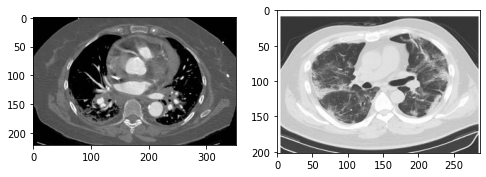

In [0]:
image_positive = cv2.imread("/content/covimg/CT_COVID/2020.02.10.20021584-p6-52%14.png")
image_negative = cv2.imread("/content/covimg/CT_NonCOVID/103.png")

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

## 4) Find out maximum and minimum dimensions of dataset images

In [0]:
home_dir = "/content/covimg/"

def get_imagesize(folder):
  max_width = -9999999
  max_height = -9999999
  min_width = 9999999
  min_height = 9999999

  for files in os.listdir(home_dir+folder):
    image = PIL.Image.open(home_dir+folder+files)
    width, height = image.size
    if width > max_width and height > max_height:
      max_width, max_height = width, height
    if width < min_width and height < min_height:
      min_width, min_height = width, height
    image.close()
  print("Mininum dimensions: ", min_width, min_height)
  print("Maximum dimensions: ", max_width, max_height)
  
print("For COVID Images:")
get_imagesize("CT_COVID/")
print("\nFor Non-COVID Images:")
get_imagesize("CT_NonCOVID/")

For COVID Images:
Mininum dimensions:  148 61
Maximum dimensions:  1637 1225

For Non-COVID Images:
Mininum dimensions:  139 114
Maximum dimensions:  1050 811


## 5) Split folders into ```train/val/split```

The extra file before split is just the metadata file :)

In [0]:
print("Number of images before split: ")
!find /content/covimg/ -type f | wc -l

split_folders.ratio('/content/covimg', output="output", seed=42, ratio=(.8, .1, .1))

print("\nNumber of images after split: ")
!find /content/output/ -type f | wc -l


Number of images before split: 
747


Copying files: 746 files [00:00, 4331.39 files/s]



Number of images after split: 
746


## 6) Define ```ImageDataGenerators``` for each subset of dataset 

Add augmentations to training generator

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range = 0.2,
                                   zoom_range = 0.2, rotation_range = 20)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/output/train',
    target_size=(224,224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/output/val',  
    target_size=(224,224), 
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    "/content/output/test",
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)


Found 596 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


## 7) Simple CNN model for baseline predictions

In [0]:

model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

## 8) Define callbacks, compile and fit dataset to model

In [0]:

filepath = "/content/drive/My Drive/CH Model/bcnn_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reducelr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

step_size_train=train_generator.n//train_generator.batch_size
val_step_size = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,
                    epochs=100, validation_data=validation_generator, 
                    validation_steps=val_step_size,callbacks=[checkpoint, early], 
                    verbose=1)

model.save("/content/drive/My Drive/CH Model/bcnn_model.hdf5")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.6989 - acc: 0.5372
Epoch 00001: val_loss improved from inf to 0.66550, saving model to /content/drive/My Drive/CH Model/bcnn_weights.hdf5
37/37 [==============================] - 8s 214ms/step - loss: 0.6989 - acc: 0.5372 - val_loss: 0.6655 - val_acc: 0.5625
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.6630 - acc: 0.5793
Epoch 00002: val_loss improved from 0.66550 to 0.59880, saving model to /content/drive/My Drive/CH Model/bcnn_weights.hdf5
37/37 [==============================] - 8s 215ms/step - loss: 0.6630 - acc: 0.5793 - val_loss: 0.5988 - val_acc: 0.7188
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.6370 - acc: 0.6397
Epoch 00003: val_loss did not improve from 0.59880
37/37 [==============================] - 8s 212ms/step - loss: 0.6370 - acc: 0.6397 - val_loss: 0.6047 - val_acc: 0.687

## 9) Define a function to plot accuracy and loss curves

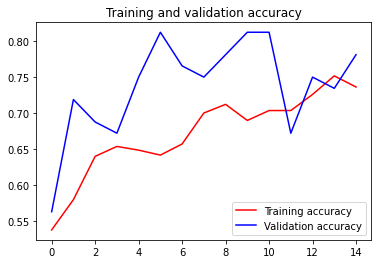

<Figure size 432x288 with 0 Axes>

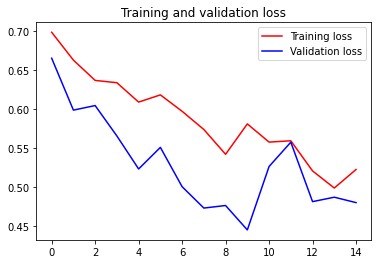

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

plot_history(history)

## 10) Calculate metrics on test set

In [0]:
model.load_weights("/content/drive/My Drive/CH Model/bcnn_weights.hdf5")
test_step_size = test_generator.n//test_generator.batch_size

y_test = test_generator.classes
y_pred =  model.predict_generator(test_generator,steps=test_step_size+1,verbose=1)

preds = []
for x in y_pred:
  if x>0.6:
    preds.append(1)
  else:
    preds.append(0)

y_pred = np.asarray(preds)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Instructions for updating:
Please use Model.predict, which supports generators.
5/5 [==============================] - 0s 82ms/step
Accuracy: 0.441558
Precision: 0.461538
Recall: 0.292683
F1 score: 0.358209
ROC AUC: 0.451897
[[22 14]
 [29 12]]


## 11) Define another model using transfer learning with MobileNetV2

Accuracy: 0.467532
Precision: 0.500000
Recall: 0.512195
F1 score: 0.506024
ROC AUC: 0.464431
[[15 21]
 [20 21]]

In [0]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in base_model.layers:
	layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

## 12) Define callbacks, compile and fit dataset to model

In [0]:

filepath = "/content/drive/My Drive/CH Model/mnet_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

step_size_train=train_generator.n//train_generator.batch_size
val_step_size = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,
                    epochs=100, validation_data=validation_generator, 
                    validation_steps=val_step_size,callbacks=[checkpoint, early], 
                    verbose=1)

model.save("/content/drive/My Drive/CH Model/mnet_model.hdf5")

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 3.4708 - acc: 0.5121
Epoch 00001: val_loss improved from inf to 0.79224, saving model to /content/drive/My Drive/CH Model/mnet_weights.hdf5
37/37 [==============================] - 11s 307ms/step - loss: 3.4708 - acc: 0.5121 - val_loss: 0.7922 - val_acc: 0.6406
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 1.5983 - acc: 0.5690
Epoch 00002: val_loss improved from 0.79224 to 0.58266, saving model to /content/drive/My Drive/CH Model/mnet_weights.hdf5
37/37 [==============================] - 10s 258ms/step - loss: 1.5983 - acc: 0.5690 - val_loss: 0.5827 - val_acc: 0.7031
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.7643 - acc: 0.6741
Epoch 00003: val_loss improved from 0.58266 to 0.54206, saving model to /content/drive/My Drive/CH Model/mnet_weights.hdf5
37/37 [==============================] - 10s 257ms/step - loss: 0.7643 - acc: 0.6741 - val_loss: 0.5421 - val_acc: 0.7188

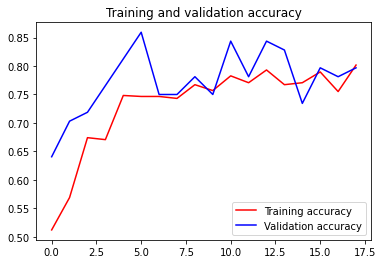

<Figure size 432x288 with 0 Axes>

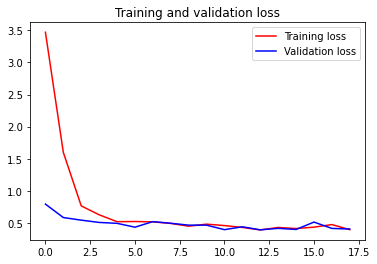

<Figure size 432x288 with 0 Axes>

In [0]:
plot_history(history)

In [0]:
model.load_weights("/content/drive/My Drive/CH Model/mnet_weights.hdf5")

y_test = test_generator.classes
y_pred =  model.predict_generator(test_generator,steps=test_step_size+1,verbose=1)

preds = []
for x in y_pred:
  if x>0.5:
    preds.append(1)
  else:
    preds.append(0)
y_pred = np.asarray(preds)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

5/5 [==============================] - 0s 72ms/step
Accuracy: 0.480519
Precision: 0.513514
Recall: 0.463415
F1 score: 0.487179
ROC AUC: 0.481707
[[18 18]
 [22 19]]


In [0]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils

class GradCAM:

	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()
	
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])

		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]
		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap
	
	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)/content/output/test/CT_COVID/2020.02.25.20021568-p23-108%12.png

In [0]:
image = load_img("/content/output/test/CT_COVID/2020.03.01.20029769-p21-73_1%0.png", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
preds = model.predict(image)
i = np.argmax(preds[0])

0

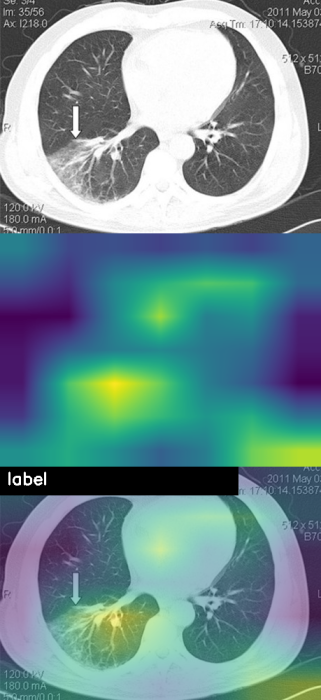

-1

In [0]:
from google.colab.patches import cv2_imshow
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, "COVID +", (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)